In [1]:
import PKoopmanDL as pkdl
import numpy as np
import matplotlib.pyplot as plt
import torch

# read the config file
config_file = "fhn.json"
solver = pkdl.ParamKoopmanDLSolverWrapper(config_file)
state_dim = 20
param_dim = 1

# set up the grid
Nx = 10
x_max = 10
x_min = -10
x_step = (x_max - x_min) / (Nx - 1)
x_grid = torch.linspace(x_min, x_max, Nx).unsqueeze(0)
state_pos = list(range(0, 2*Nx))

def vw_sample_func(row_size, col_size):
  assert (col_size == Nx * 2)
  x_grid_data = x_grid.expand(row_size, Nx)
  torch.manual_seed(0)
  a = torch.randint(0, 20, (1,)).item()
  v = torch.sin((a * torch.pi * x_grid_data)/10 + torch.pi/2)
  w = torch.zeros(v.size())
  return torch.cat([v, w], dim=1)

# set up the solver
tmp_func = lambda x: x
observable_func = pkdl.ObservableFunction(tmp_func, state_dim)
solver.setup(observable_func, vw_sample_func)
weight = torch.ones(1, solver.dictionary.dim_output)
for i in range(Nx, Nx*2):
  weight[0, i] = 100.0
K = solver.solve(weight)


2024-12-02 19:02:58,456 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating data...
2024-12-02 19:02:58,460 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating trajectories...
Generating trajectories: 100%|██████████| 499/499 [00:14<00:00, 35.64it/s]
2024-12-02 19:03:12,468 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating labels...
2024-12-02 19:03:13,390 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Data generated.
2024-12-02 19:03:13,403 PKoopmanDL: [INFO] [ParamKoopmanDLSolver] Solving...
Training: 100%|██████████| 500/500 [09:16<00:00,  1.11s/it, train_loss=6.56e-03, val_loss=9.53e-04]


2024-12-02 19:12:47,896 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating data...
2024-12-02 19:12:47,900 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating trajectories...
Generating trajectories: 100%|██████████| 498/498 [00:12<00:00, 40.95it/s]
2024-12-02 19:13:00,064 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Start generating labels...
2024-12-02 19:13:00,104 PKoopmanDL: [INFO] [ParamKoopmanDataSet] Data generated.


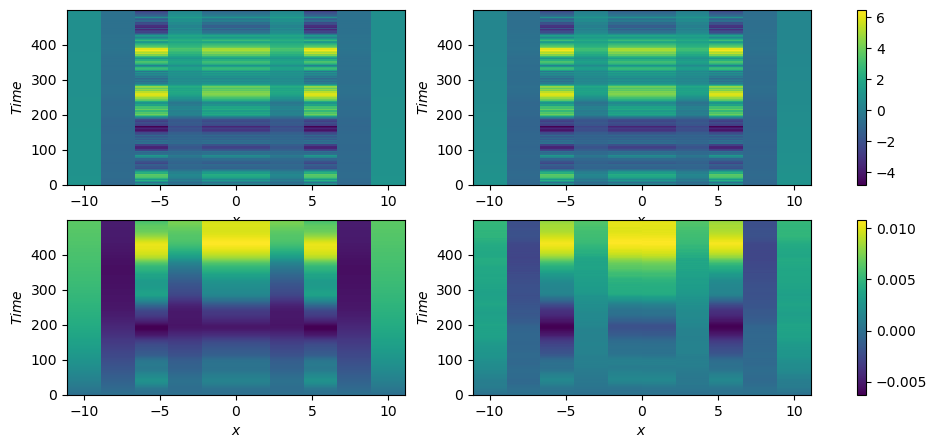

In [2]:

# predict
koopman_dynamics = pkdl.KoopmanDynamics(K, solver.dictionary, state_pos, state_dim, param_dim)
dataset_predict = pkdl.ParamKoopmanDataSet(solver.dynamics, vw_sample_func)
dataset_predict.generate_data(1, 1, solver.traj_len - 1, solver.x_min, solver.x_max, solver.param_min, solver.param_max, param_time_dependent=True)
x0 = torch.unsqueeze(dataset_predict.data_x[0], dim=0)
param = dataset_predict.data_param
p = koopman_dynamics.traj(x0, param, solver.traj_len)
x_est_traj = p[0, :, :].detach().numpy()
t_grid = np.arange(0, solver.traj_len)
x_traj = solver.dynamics.traj(x0, param, solver.traj_len)[0, :, :].detach().numpy()

X, Y = np.meshgrid(x_grid, t_grid)
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(12,5))  
c1 = axs[0, 0].pcolormesh(X, Y, x_traj[:, :Nx], shading='auto')
axs[0, 0].set_xlabel(r"$x$")
axs[0, 0].set_ylabel(r"$Time$")
c2 = axs[0, 1].pcolormesh(X, Y, x_est_traj[:, 0:Nx], shading='auto')
axs[0, 1].set_xlabel(r"$x$")
axs[0, 1].set_ylabel(r"$Time$")
c3 = axs[1, 0].pcolormesh(X, Y, x_traj[:, Nx:2*Nx], shading='auto')
axs[1, 0].set_xlabel(r"$x$")
axs[1, 0].set_ylabel(r"$Time$")
c4 = axs[1, 1].pcolormesh(X, Y, x_est_traj[:, Nx:2*Nx], shading='auto')
axs[1, 1].set_xlabel(r"$x$")
axs[1, 1].set_ylabel(r"$Time$")
cbar_row1 = fig.colorbar(c1, ax=axs[0, :])
cbar_row2 = fig.colorbar(c3, ax=axs[1, :])
plt.show()